# Steganography: Hiding Data in Plain Sight

**Steganography** is the practice of hiding a secret message in ordinary data (like an image, audio file, or text) so that the very of the message is concealed.

**Cryptography vs Steganography**:
Cryptography hides **content** (ciphertext looks suspicious). Steganography hides **existence** (the carrier looks normal).  


In [3]:
#@title LSB Steganography
import numpy as np
from PIL import Image
import io, os, zlib #zlib for deflate for lsb
import matplotlib.pyplot as plt

#this code will only work in COLAB
try:
    from google.colab import files
    IN_COLAB = True
except Exception:
    IN_COLAB = False

In [4]:
#@title bitwise 'helpers'
def remove_lsb(value, n):
    value = np.asarray(value, dtype=np.uint8)
    if n <= 0: return value
    mask = np.uint8(0xFF ^ ((1 << n) - 1))
    return value & mask

def get_lsb(value, n):
    value = np.asarray(value, dtype=np.uint8)
    if n <= 0: return np.zeros_like(value, dtype=np.uint8)
    return value & np.uint8((1 << n) - 1)

def remove_msb(value, n):
    value = np.asarray(value, dtype=np.uint8)
    if n <= 0: return value
    mask = np.uint8((1 << (8 - n)) - 1) if n < 8 else np.uint8(0)
    return value & mask

def shift(value, n):
    value = np.asarray(value, dtype=np.uint8)
    if n <= 0: return value
    return (value >> np.uint8(n)).astype(np.uint8)


# Bitwise Helper Functions for LSB Steganography

functions work on numpy arrays of unsigned 8-bit integers, which is the standard format for image pixel data


When hiding data inside an image:
- remove_lsb: Clears space in the LSBs so new bits can be inserted without affecting higher-order bits too much
- get_lsb: Extracts the hidden bits from an image.
- remove_msb: Used for bit manipulations where only the lower-order bits are relevant
- shift: Often used to align bits during embedding/extraction

lossy operations (they alter data but not too much to the human eye)

In [5]:
#@title test bit 'helpers'
test_values = np.array([255, 240, 15, 85, 170], dtype=np.uint8)

print("Original values:      ", test_values)
print("Binary representation:", [format(v, '08b') for v in test_values])

# --- remove_lsb ---
print("\nremove_lsb(values, 2):", remove_lsb(test_values, 2))
print("Binary:", [format(v, '08b') for v in remove_lsb(test_values, 2)])

# --- get_lsb ---
print("\nget_lsb(values, 2):   ", get_lsb(test_values, 2))
print("Binary:", [format(v, '08b') for v in get_lsb(test_values, 2)])

Original values:       [255 240  15  85 170]
Binary representation: ['11111111', '11110000', '00001111', '01010101', '10101010']

remove_lsb(values, 2): [252 240  12  84 168]
Binary: ['11111100', '11110000', '00001100', '01010100', '10101000']

get_lsb(values, 2):    [3 0 3 1 2]
Binary: ['00000011', '00000000', '00000011', '00000001', '00000010']


In [9]:
def to_image_array(img):

    if isinstance(img, (str, bytes, bytearray)): #checks if img is one of those data types
        img = Image.open(img)
    if img.mode not in ("RGB", "RGBA", "L"):
        img = img.convert("RGB")
    arr = np.array(img, dtype=np.uint8)
    if arr.ndim == 2:
        arr = np.stack([arr, arr, arr], axis=-1)
    if arr.shape[-1] == 4:
        arr = arr[..., :3]
    return img, arr


def bits_from_bytes(data: bytes):
    for b in data:
        for i in range(7, -1, -1):
            yield (b >> i) & 1

def bytes_from_bits(bits):
    out = bytearray()
    cur = 0
    cnt = 0
    for bit in bits:
        cur = (cur << 1) | (bit & 1)
        cnt += 1
        if cnt == 8:
            out.append(cur)
            cur = 0; cnt = 0
    return bytes(out)

def xor_bytes(data: bytes, key: bytes) -> bytes:
    if not key:
        raise ValueError("Key must not be empty.")
    return bytes(d ^ key[i % len(key)] for i, d in enumerate(data))

def show_side_by_side(img_left, title_left, img_right, title_right):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1); plt.imshow(img_left); plt.title(title_left); plt.axis("off")
    plt.subplot(1,2,2); plt.imshow(img_right); plt.title(title_right); plt.axis("off")
    plt.tight_layout(); plt.show()


Do you want to (e)ncode or (d)ecode? e
Enter a short secret key (1–32 chars): TLJ&wsMIB
📤 Upload a COVER image (PNG/JPG) to embed into:


Saving mib.jpeg to mib.jpeg
📤 Upload a .txt FILE to hide inside the image:


Saving doi.txt to doi.txt


/tmp/ipython-input-2899714541.py:31: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  return Image.fromarray(stego, mode="RGB")


Encoded and saved as: stego.png
Download the encoded image? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Show BEFORE/AFTER comparison? (y/n): y


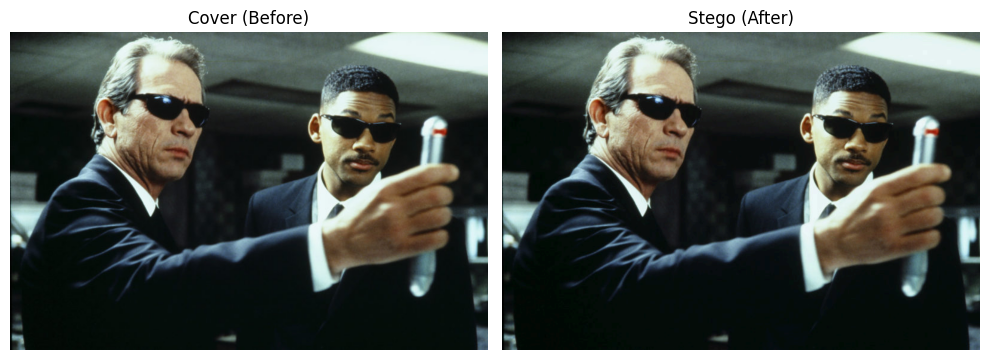

In [11]:
def encode(plaintext_bytes: bytes, hiding_spot_image, n_bits, key: bytes):
    header_len = len(plaintext_bytes).to_bytes(4, "big")
    checksum = zlib.crc32(plaintext_bytes) & 0xFFFFFFFF
    header_crc = checksum.to_bytes(4, "big")
    cipher = xor_bytes(plaintext_bytes, key)
    full = header_len + header_crc + cipher

    img, arr = to_image_array(hiding_spot_image)
    h, w, c = arr.shape
    if c < 3:
        raise ValueError("Expected an RGB-like image.")

    capacity_bits = h * w * c * n_bits
    needed_bits = len(full) * 8
    if needed_bits > capacity_bits:
        raise ValueError(f"Message too large. Need {needed_bits} bits, have {capacity_bits} bits.")

    flat = arr.reshape(-1)
    flat = remove_lsb(flat, n_bits)

    bit_stream = list(bits_from_bytes(full))
    pad = (-len(bit_stream)) % n_bits
    if pad: bit_stream += [0] * pad

    grouped = np.array(bit_stream, dtype=np.uint8).reshape(-1, n_bits)
    powers = (1 << np.arange(n_bits - 1, -1, -1, dtype=np.uint8))
    values = (grouped * powers).sum(axis=1).astype(np.uint8)

    flat[:len(values)] |= values
    stego = flat.reshape(h, w, c)
    return Image.fromarray(stego, mode="RGB")

def decode(hiding_spot_image, n_bits, key: bytes) -> bytes:
    _img, arr = to_image_array(hiding_spot_image)
    flat = arr.reshape(-1)
    vals = get_lsb(flat, n_bits)

    bits = []
    for v in vals:
        for i in range(n_bits - 1, -1, -1):
            bits.append((v >> i) & 1)

    if len(bits) < 64:
        raise ValueError("Not enough bits for header.")

    # length
    length_bits = bits[:32]
    length_bytes = int.from_bytes(bytes_from_bits(length_bits), "big")
    # crc
    crc_bits = bits[32:64]
    expected_crc = int.from_bytes(bytes_from_bits(crc_bits), "big")

    total_bits = 64 + length_bytes * 8
    if total_bits > len(bits):
        raise ValueError("Image does not contain a full payload (truncated).")

    cipher_bits = bits[64:total_bits]
    cipher = bytes_from_bits(cipher_bits)
    plain = xor_bytes(cipher, key)

    if (zlib.crc32(plain) & 0xFFFFFFFF) != expected_crc:
        raise ValueError("CRC check failed — wrong key or corrupted data.")
    return plain


def colab_upload(accept_desc="file"):
    if not IN_COLAB:
        raise RuntimeError(f"Upload requires Colab: please place the {accept_desc} in your working directory and modify the code to use a path.")
    up = files.upload()
    if not up:
        raise RuntimeError(f"No {accept_desc} uploaded.")
    name = next(iter(up.keys()))
    return name, up[name]

def safe_key_input(prompt="Enter a short secret key (1–32 chars): "):
    key = input(prompt).strip()
    if not (1 <= len(key) <= 32):
        raise ValueError("Key length must be 1–32 characters.")
    return key.encode("utf-8")

#i/o for user to download nd compare
try:
    mode = input("Do you want to (e)ncode or (d)ecode? ").strip().lower()
    if mode not in ("e", "d"):
        raise ValueError("Please type 'e' for encode or 'd' for decode.")
    n_bits = 2 #changed to 2 bits each time

    if mode == "e":

        key = safe_key_input("Enter a short secret key (1–32 chars): ")

        print("📤 Upload a COVER image (PNG/JPG) to embed into:")
        cover_img_name, _ = colab_upload("cover image")

        print("📤 Upload a .txt FILE to hide inside the image:")
        txt_name, txt_bytes = colab_upload(".txt file")
        payload = txt_bytes  # use raw bytes, user provided .txt

        cover_img_pil = Image.open(cover_img_name)
        stego_img = encode(payload, cover_img_pil, n_bits, key)
        out_name = "stego.png"
        stego_img.save(out_name)
        print(f"Encoded and saved as: {out_name}")

        # offer download
        want_dl = input("Download the encoded image? (y/n): ").strip().lower()
        if want_dl == "y" and IN_COLAB:
            files.download(out_name)

        # ooffer compare
        want_compare = input("Show BEFORE/AFTER comparison? (y/n): ").strip().lower()
        if want_compare == "y":
            c_img, cover_arr = to_image_array(cover_img_pil)
            s_img, stego_arr = to_image_array(stego_img)
            show_side_by_side(cover_arr, "Cover (Before)", stego_arr, "Stego (After)")

    else:
        key = safe_key_input("Enter the secret key used for encoding (1–32 chars): ")

        print("Upload the ENCODED image (stego):")
        stego_name, _ = colab_upload("encoded image")
        stego_img_pil = Image.open(stego_name)

        # Decode text
        try:
            recovered = decode(stego_img_pil, n_bits, key)
            #fallback to bytes print
            try:
                text_out = recovered.decode("utf-8")
                print("Decoded text:\n", text_out)
            except UnicodeDecodeError:
                print("Decoded bytes (not UTF-8):", recovered)
        except Exception as e:
            raise

        # Optional comparison with original cover
        compare_choice = input("Upload the ORIGINAL cover to compare with the encoded image? (y/n): ").strip().lower()
        if compare_choice == "y":
            print("📤 Upload the ORIGINAL cover image:")
            cover_name, _ = colab_upload("original cover image")
            cover_img_pil = Image.open(cover_name)
            c_img, cover_arr = to_image_array(cover_img_pil)
            s_img, stego_arr = to_image_array(stego_img_pil)
            show_side_by_side(cover_arr, "Cover (Before)", stego_arr, "Stego (Encoded)")
        else:
            # Still show the encoded image alone (so the user sees something visual)
            s_img, stego_arr = to_image_array(stego_img_pil)
            show_side_by_side(stego_arr, "Stego (Encoded)", stego_arr, "Stego (Encoded)")

except Exception as e:
    print("❌ Error:", e)

Do you want to (e)ncode or (d)ecode? d
Enter the secret key used for encoding (1–32 chars): TLJ&wsMIB
Upload the ENCODED image (stego):


Saving stego (3).png to stego (3).png
Decoded text:
 The unanimous Declaration of the thirteen united States of America,

When in the Course of human events, it becomes necessary for one people to dissolve the political bands which have connected them with another, and to assume among the powers of the earth, the separate and equal station to which the Laws of Nature and of Nature's God entitle them, a decent respect to the opinions of mankind requires that they should declare the causes which impel them to the separation.

We hold these truths to be self-evident, that all men are created equal, that they are endowed by their Creator with certain unalienable Rights, that among these are Life, Liberty and the pursuit of Happiness.—That to secure these rights, Governments are instituted among Men, deriving their just powers from the consent of the governed,—That whenever any Form of Government becomes destructive of these ends, it is the Right of the People to alter or to abolish it, and

Saving mib.jpeg to mib (1).jpeg


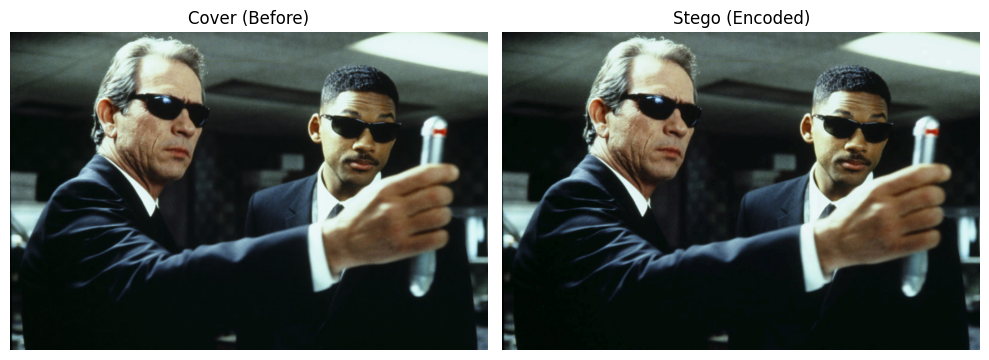

In [12]:
try:
    mode = input("Do you want to (e)ncode or (d)ecode? ").strip().lower()
    if mode not in ("e", "d"):
        raise ValueError("Please type 'e' for encode or 'd' for decode.")
    n_bits = 2 #changed to 2 bits each time

    if mode == "e":

        key = safe_key_input("Enter a short secret key (1–32 chars): ")

        print("📤 Upload a COVER image (PNG/JPG) to embed into:")
        cover_img_name, _ = colab_upload("cover image")

        print("📤 Upload a .txt FILE to hide inside the image:")
        txt_name, txt_bytes = colab_upload(".txt file")
        payload = txt_bytes  # use raw bytes, user provided .txt

        cover_img_pil = Image.open(cover_img_name)
        stego_img = encode(payload, cover_img_pil, n_bits, key)
        out_name = "stego.png"
        stego_img.save(out_name)
        print(f"Encoded and saved as: {out_name}")

        # offer download
        want_dl = input("Download the encoded image? (y/n): ").strip().lower()
        if want_dl == "y" and IN_COLAB:
            files.download(out_name)

        # ooffer compare
        want_compare = input("Show BEFORE/AFTER comparison? (y/n): ").strip().lower()
        if want_compare == "y":
            c_img, cover_arr = to_image_array(cover_img_pil)
            s_img, stego_arr = to_image_array(stego_img)
            show_side_by_side(cover_arr, "Cover (Before)", stego_arr, "Stego (After)")

    else:
        key = safe_key_input("Enter the secret key used for encoding (1–32 chars): ")

        print("Upload the ENCODED image (stego):")
        stego_name, _ = colab_upload("encoded image")
        stego_img_pil = Image.open(stego_name)

        # Decode text
        try:
            recovered = decode(stego_img_pil, n_bits, key)
            #fallback to bytes print
            try:
                text_out = recovered.decode("utf-8")
                print("Decoded text:\n", text_out)
            except UnicodeDecodeError:
                print("Decoded bytes (not UTF-8):", recovered)
        except Exception as e:
            raise

        # Optional comparison with original cover
        compare_choice = input("Upload the ORIGINAL cover to compare with the encoded image? (y/n): ").strip().lower()
        if compare_choice == "y":
            print("📤 Upload the ORIGINAL cover image:")
            cover_name, _ = colab_upload("original cover image")
            cover_img_pil = Image.open(cover_name)
            c_img, cover_arr = to_image_array(cover_img_pil)
            s_img, stego_arr = to_image_array(stego_img_pil)
            show_side_by_side(cover_arr, "Cover (Before)", stego_arr, "Stego (Encoded)")
        else:
            # Still show the encoded image alone (so the user sees something visual)
            s_img, stego_arr = to_image_array(stego_img_pil)
            show_side_by_side(stego_arr, "Stego (Encoded)", stego_arr, "Stego (Encoded)")

except Exception as e:
    print("❌ Error:", e)